### Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F

## Dataset And Dataloader

In [2]:
class TemporalDataset(Dataset):
    def __init__(self, features, labels, sequence_length):
        self.features = features
        self.labels = labels
        self.sequence_length = sequence_length
        self.max_length = len(features)

    def __len__(self):
        return len(self.features) - self.sequence_length + 1

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length

        # Extract the sequence of features
        sequence_features = self.features[idx:idx_end]

        # Handle NaN values: replace NaNs with zeros or any other strategy
        sequence_features = torch.tensor(sequence_features, dtype=torch.float32)
        sequence_features[torch.isnan(sequence_features)] = 0.0

        # Extract the label
        label = torch.tensor(self.labels[idx_end - 1], dtype=torch.long)

        return sequence_features, label


# File paths for training, validation, and testing
train_file = "../concatenated_data_one_hot_train.csv"
val_file = "../concatenated_data_one_hot_test.csv"
test_file = "../concatenated_data_one_hot_val.csv"

# Sequence length for creating sequences
sequence_length = 10  # You can adjust this based on your preference

# Read CSV files
train_data = pd.read_csv(train_file)
val_data = pd.read_csv(val_file)
test_data = pd.read_csv(test_file)

# Specify columns to normalize
columns_to_normalize = ['RotationRate',	'HorizontalRate',	'VerticalRate'	,'DuctionRate'	,'FlexionRate',	'StrengthAmplitude']  # Replace with your actual column names

# Normalize selected columns using StandardScaler
scaler = StandardScaler()
train_data[columns_to_normalize] = scaler.fit_transform(train_data[columns_to_normalize])
val_data[columns_to_normalize] = scaler.transform(val_data[columns_to_normalize])
test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

# Extract features and labels
train_features = train_data.drop(['temporal_order', 'action'], axis=1).values
train_labels = train_data['action'].values

val_features = val_data.drop(['temporal_order', 'action'], axis=1).values
val_labels = val_data['action'].values

test_features = test_data.drop(['temporal_order', 'action'], axis=1).values
test_labels = test_data['action'].values

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# Create datasets
train_dataset = TemporalDataset(train_features, train_labels, sequence_length)
val_dataset = TemporalDataset(val_features, val_labels, sequence_length)
test_dataset = TemporalDataset(test_features, test_labels, sequence_length)

# Batch size for the data loader
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print a sample from the training DataLoader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    # Print the content of the first batch
    if batch_idx == 0:
        print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        for i in range(min(5, batch_size)):  # Print only the first 5 samples
            print(f"Sample {i + 1}: {inputs[i]}, Label: {labels[i]}")

    # Break out of the loop after printing the first batch
    break


Batch 1 - Inputs shape: torch.Size([64, 10, 42]), Labels shape: torch.Size([64])
Sample 1: tensor([[ 3.5722e+00, -2.4778e-02,  1.4519e-01, -1.5582e-01,  1.0847e-01,
         -1.5393e-01,  1.2598e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.6036e+00, -5.8052e-02,  6.6481e-02, -5.6467e-02,  5.7630e-02,
         -5.3169e-02,  3.3369e-01,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00

## Auto Encoder Model

Epoch [1/10], Training Loss: -38.5725
Epoch [1/10], Validation Loss: -66.5975
Epoch [2/10], Training Loss: -69.6407
Epoch [2/10], Validation Loss: -66.7233
Epoch [3/10], Training Loss: -69.6921
Epoch [3/10], Validation Loss: -66.7565
Epoch [4/10], Training Loss: -69.7121
Epoch [4/10], Validation Loss: -66.7739
Epoch [5/10], Training Loss: -69.7237
Epoch [5/10], Validation Loss: -66.7849
Epoch [6/10], Training Loss: -69.7307
Epoch [6/10], Validation Loss: -66.7905
Epoch [7/10], Training Loss: -69.7349
Epoch [7/10], Validation Loss: -66.7967
Epoch [8/10], Training Loss: -69.7390
Epoch [8/10], Validation Loss: -66.8022
Epoch [9/10], Training Loss: -69.7425
Epoch [9/10], Validation Loss: -66.8082
Epoch [10/10], Training Loss: -69.7453
Epoch [10/10], Validation Loss: -66.8129


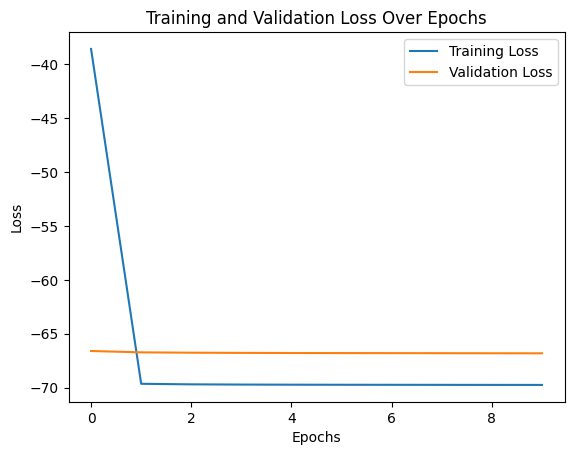

Overall Training Percentage: 100.00%
Overall Validation Percentage: 100.00%


In [3]:
import torch.optim as optim
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # Additional layer
            nn.ReLU(),
            nn.Linear(64, encoding_size),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, 64),  # Additional layer
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Parameters
input_size = 42 * 10  # input data size
encoding_size = 32  # encoding dimension

# Create the Autoencoder model
autoencoder_model = Autoencoder(input_size, encoding_size)

# Change the loss function and optimizer
criterion = nn.BCELoss()  # Use Binary Cross-Entropy Loss for binary data
optimizer = optim.SGD(autoencoder_model.parameters(), lr=0.001)  # Use SGD optimizer

# Training and validation loops with loss diagrams
num_epochs = 10
losses = []  # to store the training loss values for plotting
validation_losses = []  # to store the validation loss values for plotting

for epoch in range(num_epochs):
    autoencoder_model.train()  # Set the model to training mode
    epoch_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        optimizer.zero_grad()
        outputs = autoencoder_model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)  # accumulate the training loss for the entire dataset

    average_loss = epoch_loss / len(train_loader.dataset)
    losses.append(average_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}')

    # Validation loop
    autoencoder_model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)
            outputs = autoencoder_model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item() * inputs.size(0)  # accumulate the validation loss for the entire dataset

    average_validation_loss = validation_loss / len(val_loader.dataset)
    validation_losses.append(average_validation_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_validation_loss:.4f}')

# Plot the training and validation loss diagrams
plt.plot(losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Calculate overall training and validation percentages
overall_training_percentage = (1 - average_loss / (input_size * len(train_loader.dataset))) * 100
overall_validation_percentage = (1 - average_validation_loss / (input_size * len(val_loader.dataset))) * 100

print(f'Overall Training Percentage: {overall_training_percentage:.2f}%')
print(f'Overall Validation Percentage: {overall_validation_percentage:.2f}%')

# After training, you can use the encoder part of the model to extract features
with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(data.size(0), -1)
        encoded_features = autoencoder_model.encoder(data)
        # Now 'encoded_features' contains the reduced-dimensional representation of your data



## LSTM Model

LSTM_Model(
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


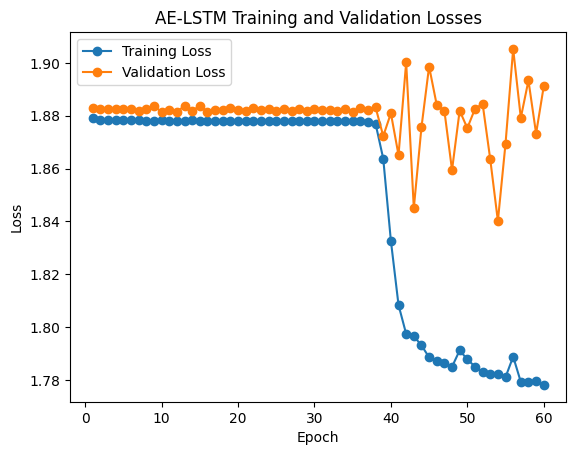

AE-LSTM Test Accuracy: 31.18


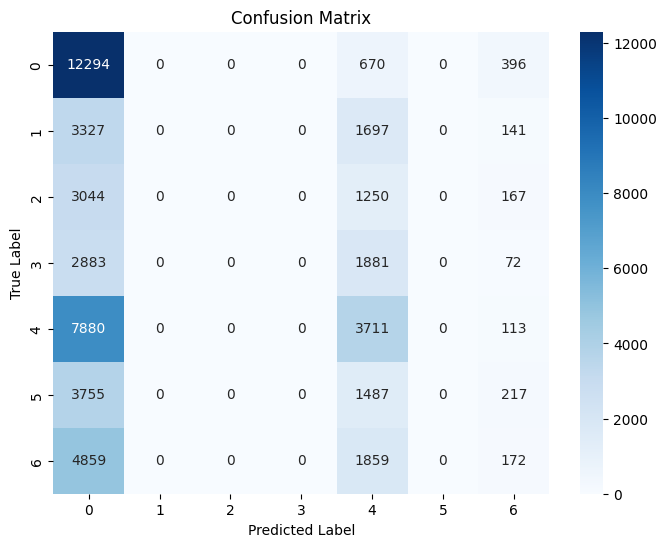

In [4]:
# LSTM Model with Softmax
class LSTM_Model(nn.Module):
    def __init__(self, encoding_size, hidden_size, num_layers, output_size):
        super(LSTM_Model, self).__init__()

        # LSTM
        self.lstm = nn.LSTM(encoding_size, hidden_size, num_layers, batch_first=True)

        # Output layer with Softmax activation
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # LSTM
        x_lstm, _ = self.lstm(x)

        # If x_lstm is 3D or higher, select the last time step; otherwise, use x_lstm as is
        if x_lstm.dim() > 2:
            x_output = self.fc(x_lstm[:, -1, :])
        else:
            x_output = self.fc(x_lstm)

        # Apply softmax activation
        x_output = self.softmax(x_output)

        return x_output

# Input and output sizes based on data

hidden_size_lstm = 64
num_layers_lstm = 2
output_size_lstm = 7  # Action prediction

# LSTM model
lstm_model = LSTM_Model(encoding_size, hidden_size_lstm, num_layers_lstm, output_size_lstm)

# Print the model architecture
print(lstm_model)

# loss function and optimizer for LSTM
criterion_ae_lstm = nn.CrossEntropyLoss()
optimizer_ae_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

# Set the number of epochs for AE-LSTM
epochs_ae_lstm = 60

# Training loop for AE-LSTM
train_losses_ae_lstm = []
val_losses_ae_lstm = []

for epoch in range(epochs_ae_lstm):
    lstm_model.train()
    total_loss_ae_lstm = 0.0

    for data, labels in train_loader:
        # Assuming 'encoded_features' is obtained from the autoencoder
        encoded_features = autoencoder_model.encoder(data.view(data.size(0), -1))

        optimizer_ae_lstm.zero_grad()
        outputs_ae_lstm = lstm_model(encoded_features)
        loss_ae_lstm = criterion_ae_lstm(outputs_ae_lstm, labels)
        loss_ae_lstm.backward()
        optimizer_ae_lstm.step()
        total_loss_ae_lstm += loss_ae_lstm.item()

    average_train_loss_ae_lstm = total_loss_ae_lstm / len(train_loader)
    train_losses_ae_lstm.append(average_train_loss_ae_lstm)

    # Validation loop for AE-LSTM
    lstm_model.eval()
    total_val_loss_ae_lstm = 0.0

    with torch.no_grad():
        for val_data, val_labels in val_loader:
            encoded_features_val = autoencoder_model.encoder(val_data.view(val_data.size(0), -1))
            val_outputs_ae_lstm = lstm_model(encoded_features_val)
            val_loss_ae_lstm = criterion_ae_lstm(val_outputs_ae_lstm, val_labels)
            total_val_loss_ae_lstm += val_loss_ae_lstm.item()

    average_val_loss_ae_lstm = total_val_loss_ae_lstm / len(val_loader)
    val_losses_ae_lstm.append(average_val_loss_ae_lstm)

# Plot overall training and validation losses
plt.plot(range(1, epochs_ae_lstm + 1), train_losses_ae_lstm, label='Training Loss', marker='o')
plt.plot(range(1, epochs_ae_lstm + 1), val_losses_ae_lstm, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('AE-LSTM Training and Validation Losses')
plt.show()

# After training AE-LSTM, you can use it for predictions on the test set
lstm_model.eval()
total_test_loss_ae_lstm = 0.0

all_labels_test_ae_lstm = []
all_predictions_test_ae_lstm = []

with torch.no_grad():
    for test_data, test_labels in test_loader:
        encoded_features_test = autoencoder_model.encoder(test_data.view(test_data.size(0), -1))
        test_outputs_ae_lstm = lstm_model(encoded_features_test)
        test_loss_ae_lstm = criterion_ae_lstm(test_outputs_ae_lstm, test_labels)
        total_test_loss_ae_lstm += test_loss_ae_lstm.item()

        _, predicted_test_ae_lstm = test_outputs_ae_lstm.max(1)
        all_labels_test_ae_lstm.extend(test_labels.numpy())
        all_predictions_test_ae_lstm.extend(predicted_test_ae_lstm.numpy())

average_test_loss_ae_lstm = total_test_loss_ae_lstm / len(test_loader)
# print(f"AE-LSTM Test Loss: {average_test_loss_ae_lstm:.4f}")

# Calculate AE-LSTM Accuracy
accuracy_ae_lstm = (np.array(all_labels_test_ae_lstm) == np.array(all_predictions_test_ae_lstm)).mean()
print(f"AE-LSTM Test Accuracy: {accuracy_ae_lstm * 100:.2f}")

# Create Confusion Matrix
cm = confusion_matrix(all_labels_test_ae_lstm, all_predictions_test_ae_lstm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(output_size_lstm), yticklabels=range(output_size_lstm))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
